# Building a Chatbot Agent in LangGraph

In this tutorial, we will build a support chatbot using LangGraph. We will implement this chatbot via a graph workflow using nodes and edges.

The chatbot will:

- Answer common questions by searching the web.
- Use custom tools to enhance its capabilities.
- Maintain conversation state across calls.

This tutorial builds the foundation for more complex workflows and design patterns later in the course.

### Imports
We start by importing the necessary libraries:

In [1]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from datetime import datetime
from typing import Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv
_ = load_dotenv()

### Defining the Model
Initialize the language model:

In [2]:
llm = ChatOpenAI(model="gpt-4o")

### Defining the Tools
We will define two tools:

- Tavily Search Tool: To fetch relevant information from the web.
- Current Date and Time Tool: Helps the chatbot respond to time-based queries.


In [3]:
# Tavily Search Tool
tavily_search = TavilySearchResults(max_results=2)

# Current Date and Time Tool
@tool
def get_current_date():
    """Returns the current date and time. Use this tool first for any time-based queries."""
    return f"The current date is: {datetime.now().strftime('%d %B %Y')}"

In [4]:
# list of tools for the agent
tools = [tavily_search, get_current_date]

### Binding Tools to the LLM
We bind the tools to the language model:

In [5]:
llm_with_tools = llm.bind_tools(tools)

### Defining the StateGraph
We define the state of our chatbot using StateGraph. The State consists of a messages list, which will store the conversation history.


In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Defining the Graph Nodes
We define a chatbot node, which represents the LLM's response generation. We also define a tool node to handle tool calls.

In [7]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [8]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

### Defining the Graph Edges
We define how the chatbot transitions between nodes:

In [9]:
# Conditional edge to decide whether to use tools, this is a prebuilt conditional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)

# If tools are used, return to the chatbot to process the tool output
graph_builder.add_edge("tools", "chatbot")

# Set the entry point of the graph
graph_builder.set_entry_point("chatbot")

### Compiling the Graph
We compile the graph to create a runnable chatbot:

In [10]:
graph = graph_builder.compile()

### Visualizing the Chatbot's Workflow
We can visualize the chatbot's workflow using LangGraph's graph visualization tools:

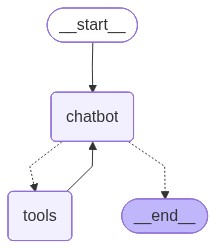

In [11]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Chatbot
Now, we can interact with our chatbot.

#### Helper Functions
We define helper functions to process and render the chatbot's responses:

In [12]:
from IPython.display import Markdown, display

def render_markdown(md_string):
    display(Markdown(md_string))

def process_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
    return message

def process_query(query, config=None):
    inputs = {"messages": [("user", query)]}
    message = process_stream(graph.stream(inputs, config, stream_mode="values"))
    render_markdown(f"## Answer:\n{message.content}")


#### Testing the Chatbot
We can now test the chatbot with various queries:

In [13]:
process_query("Hello! What can you do?")

================================ Human Message =================================

Hello! What can you do?
================================== Ai Message ==================================

Hello! I can help with a variety of tasks, including:

1. **Answering Questions:** I can provide information on a wide range of topics, including general knowledge, science, history, and more.

2. **Current Events:** I can look up the latest news and current events.

3. **Time and Date:** I can tell you the current date and time.

4. **Search Engines:** I can use search engines to find specific information online.

If you have a specific question or task in mind, feel free to ask!


## Answer:
Hello! I can help with a variety of tasks, including:

1. **Answering Questions:** I can provide information on a wide range of topics, including general knowledge, science, history, and more.

2. **Current Events:** I can look up the latest news and current events.

3. **Time and Date:** I can tell you the current date and time.

4. **Search Engines:** I can use search engines to find specific information online.

If you have a specific question or task in mind, feel free to ask!

In [14]:
# Query that requires current date
process_query("What is the current date?")

================================ Human Message =================================

What is the current date?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_CD5gXprURmjpES6STD8Li566)
 Call ID: call_CD5gXprURmjpES6STD8Li566
  Args:
================================= Tool Message =================================
Name: get_current_date

The current date is: 15 September 2025
================================== Ai Message ==================================

Today's date is September 15, 2025.


## Answer:
Today's date is September 15, 2025.

In [15]:
# Query that triggers the Tavily search tool
process_query("What is LangGraph?")

================================ Human Message =================================

What is LangGraph?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_abRGfMbgRFUbAoyy4eszen2e)
 Call ID: call_abRGfMbgRFUbAoyy4eszen2e
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.ibm.com/think/topics/langgraph", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGrap

## Answer:
LangGraph is an open-source AI agent framework created by LangChain, designed to build, deploy, and manage complex generative AI agent workflows. It provides tools and libraries that enable users to create, run, and optimize large language models (LLMs) efficiently and at scale. LangGraph uses graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow.

Key features of LangGraph include:

- **Agent Systems:** It provides a framework for building agent-based systems, useful in applications like robotics, autonomous vehicles, or video games.
- **LLM Applications:** It enables developers to build sophisticated AI models that learn and improve over time.
- **Graph-Based Architecture:** This architecture allows users to scale AI workflows without sacrificing efficiency, using enhanced decision-making by modeling complex relationships between nodes.

LangGraph allows for more variable and nuanced agent behaviors compared to linear execution models, making it a significant advancement in AI agent development. It is designed to influence the future direction of artificial intelligence by offering a flexible, graph-based framework for agent construction and execution.

In [16]:
# Time-based query about an event
process_query("When is the next olympics?")

================================ Human Message =================================

When is the next olympics?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_6ReT1NDyKkR91Eae1Rb0WHJG)
 Call ID: call_6ReT1NDyKkR91Eae1Rb0WHJG
  Args:
  tavily_search_results_json (call_RKcayrngZyCVnKjejSIv9ynB)
 Call ID: call_RKcayrngZyCVnKjejSIv9ynB
  Args:
    query: next Olympics date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.nbcolympics.com/news/when-are-next-winter-olympics-milan-cortina-2026-dates-venues-and-more", "content": "## When are the next Olympics?\n\nThe next Olympics will be the 2026 Milan Cortina Olympics. The Winter Olympics will take place from February 6 to February 22, with the Paralympics following from March 6 to March 15.\n\n## Where are the next Olympics?"}, {"url": "https://www.nbcolympics.com/news/where-and-when-are-

## Answer:
The next Olympics will be the 2026 Winter Olympics, taking place in Milan Cortina from February 6 to February 22, 2026. The Paralympics will follow from March 6 to March 15, 2026. 

After that, the Summer Olympics will be held in Los Angeles from July 14 to July 30, 2028.

## Need for Memory

Taking a look at an example of where the current chatbot falls short when remembering previous interactions.

In [17]:
process_query("Hi. My name is Sajal. Who are you?")

================================ Human Message =================================

Hi. My name is Sajal. Who are you?
================================== Ai Message ==================================

Hello Sajal! I'm an AI assistant here to help you with information and answer your questions. How can I assist you today?


## Answer:
Hello Sajal! I'm an AI assistant here to help you with information and answer your questions. How can I assist you today?

In [18]:
process_query("What is my name?")

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal data about you, including your name.


## Answer:
I'm sorry, but I don't have access to personal data about you, including your name.

### Adding Memory to the Chatbot
To maintain conversation state across calls, we use LangGraph's checkpointing system.

#### Setting Up Checkpointing
We create a MemorySaver checkpointer:

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [20]:
# Compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)

#### Using Thread IDs for Conversation State
We can maintain separate conversation threads by providing a thread_id in the configuration:

In [21]:
config_user_1 = {"thread_id": "user_1"}
process_query("Hi. My name is Sajal. Who are you?", config=config_user_1)

================================ Human Message =================================

Hi. My name is Sajal. Who are you?
================================== Ai Message ==================================

Hello Sajal! I'm an AI language model here to assist you with information, answer questions, and help with various tasks. How can I assist you today?


## Answer:
Hello Sajal! I'm an AI language model here to assist you with information, answer questions, and help with various tasks. How can I assist you today?

In [22]:
process_query("What is my name?", config=config_user_1)

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Sajal.


## Answer:
Your name is Sajal.

In [23]:
# Checking if memory is shared across threads
config_user_2 = {"thread_id": "user_2"}
process_query("What is my name?", config=config_user_2)

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. Therefore, I don't know your name. If you'd like, you can tell me your name or any other details you'd like to share.


## Answer:
I'm sorry, but I don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. Therefore, I don't know your name. If you'd like, you can tell me your name or any other details you'd like to share.

### Conclusion


Congratulations on building your own chatbot agent from scratch with LangGraph. Be sure to go through the next few tutorials to learn more about adding human in the loop capabilities to this agent!
